# Data Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

In [3]:
plt.rcParams['font.family'] = 'Arial'

In [26]:
years = list(range(2011, 2025))
data_folder_path = '../data/earning/'
file_paths = [str(year) + '_earnings.csv' for year in years]
file_paths = [data_folder_path + file_path for file_path in file_paths]

In [27]:
# Remove symbols in currency values and convert to float
def clean_currency(val):
    if isinstance(val, str):
        val = val.replace('$', '').replace(',', '').replace('(','').replace(')','').strip()
        if val == '-' or val == '0.00':
            return None
        return float(val)
    return val

In [40]:
# Read and process each CSV file
dfs = []
currency_columns = ['REGULAR','RETRO','OTHER','OVERTIME','INJURED','DETAIL','QUINN_EDUCATION','TOTAL_GROSS']

for year, path in zip(years, file_paths):
    df = pd.read_csv(path, encoding='ISO-8859-1')
    df['YEAR'] = year
    print(year)
    for col in currency_columns:
        if col in df.columns:
            # Clean the currency columns
            df[col] = df[col].apply(clean_currency)
        else:
            print(f"Warning: Column '{col}' not found in {year} data.")

    dfs.append(df)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [47]:
# print unique values of department name for each year
for year, df in zip(years, dfs):
    print(f"Unique department names for {year}:")
    unique_departments = df['DEPARTMENT_NAME'].unique()
    print(len(unique_departments))
    print("\n")

Unique department names for 2011:
49


Unique department names for 2012:
49


Unique department names for 2013:
51


Unique department names for 2014:
239


Unique department names for 2015:
233


Unique department names for 2016:
228


Unique department names for 2017:
227


Unique department names for 2018:
226


Unique department names for 2019:
230


Unique department names for 2020:
227


Unique department names for 2021:
232


Unique department names for 2022:
232


Unique department names for 2023:
234


Unique department names for 2024:
231




In [29]:
# Concatenate all year dataframes into a single dataframe
full_data = pd.concat(dfs, ignore_index=True)

# Check for missing values
missing_values = full_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)
full_data['DEPARTMENT_NAME'] = full_data['DEPARTMENT_NAME'].fillna('')

# Remove rows missing TOTAL_GROSS
full_data = full_data.dropna(subset=['TOTAL_GROSS'])

# Print the stats of the full dataset
print("Full dataset statistics:")
print(full_data.describe(include='all'))

# Seperate BPD and non-BPD data
bpd_data = full_data[full_data['DEPARTMENT_NAME'].str.upper().str.contains('POLICE')]
non_bpd_data = full_data[~full_data['DEPARTMENT_NAME'].str.upper().str.contains('POLICE')]

Missing values in each column:
_ID                297906
NAME                    6
DEPARTMENT_NAME         6
TITLE                   6
REGULAR             13327
RETRO              143778
OTHER              125559
OVERTIME           222356
INJURED            298158
DETAIL             285465
QUINN_EDUCATION    299682
TOTAL_GROSS             8
ZIP CODE           297906
YEAR                    0
_id                274806
ZIP                274806
POSTAL              64319
dtype: int64
Full dataset statistics:
                 _ID              NAME           DEPARTMENT_NAME    TITLE   
count   20509.000000            318407                    318407   318407  \
unique           NaN             53198                       445     2734   
top              NaN  Sullivan,Michael  Boston Police Department  Teacher   
freq             NaN                48                     43829    75050   
mean    10255.000000               NaN                       NaN      NaN   
std      5920.582671       

# How have BPD paychecks changed year-over-year?

In [30]:
# Calcaulate average gross
bpd_avg = bpd_data.groupby('YEAR')['TOTAL_GROSS'].mean().reset_index(name='BPD_AVG_GROSS')
non_bpd_avg = non_bpd_data.groupby('YEAR')['TOTAL_GROSS'].mean().reset_index(name='NON_BPD_AVG_GROSS')

avg_comparison = pd.merge(bpd_avg, non_bpd_avg, on='YEAR', how='outer').sort_values('YEAR')

avg_comparison

,YEAR,BPD_AVG_GROSS,NON_BPD_AVG_GROSS
0,2011,96421.474132,57553.082168
1,2012,97515.361269,56290.826094
2,2013,99771.862159,55538.289264
3,2014,112589.650642,59304.269696
4,2015,118041.488626,63268.735794
5,2016,124787.164775,62942.269980
6,2017,124254.563280,62820.904814
7,2018,131321.462320,63828.300246
8,2019,127094.346316,68909.359765
9,2020,132487.610436,74998.581716


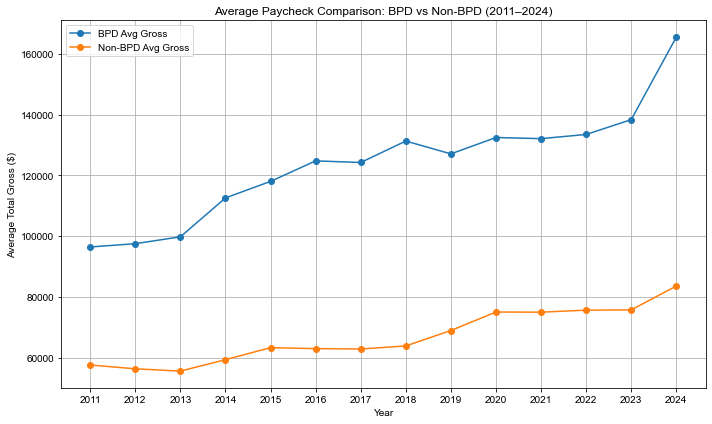

In [31]:
# Plot the average paycheck for BPD and non-BPD

plt.figure(figsize=(10, 6))
plt.plot(avg_comparison['YEAR'], avg_comparison['BPD_AVG_GROSS'], marker='o', label='BPD Avg Gross')
plt.plot(avg_comparison['YEAR'], avg_comparison['NON_BPD_AVG_GROSS'], marker='o', label='Non-BPD Avg Gross')
plt.title('Average Paycheck Comparison: BPD vs Non-BPD (2011–2024)')
plt.xlabel('Year')
plt.ylabel('Average Total Gross ($)')
plt.grid(True)
plt.legend()
plt.xticks(avg_comparison['YEAR'])
plt.tight_layout()
plt.show()

# How much BPD officer pay came from injury pay?

In [34]:
# Drop rows with missing INJURED values
bpd_data_dropna = bpd_data.dropna(subset=['INJURED'])

# Calculate the ratio of injured pay to total gross
bpd_data_dropna['INJURED_RATIO'] = bpd_data_dropna['INJURED'] / bpd_data_dropna['TOTAL_GROSS']


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_94664/3637093187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bpd_data_dropna['INJURED_RATIO'] = bpd_data_dropna['INJURED'] / bpd_data_dropna['TOTAL_GROSS']


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_94664/1374641421.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='YEAR', y='INJURED_RATIO', data=bpd_data_dropna, palette='Set3')


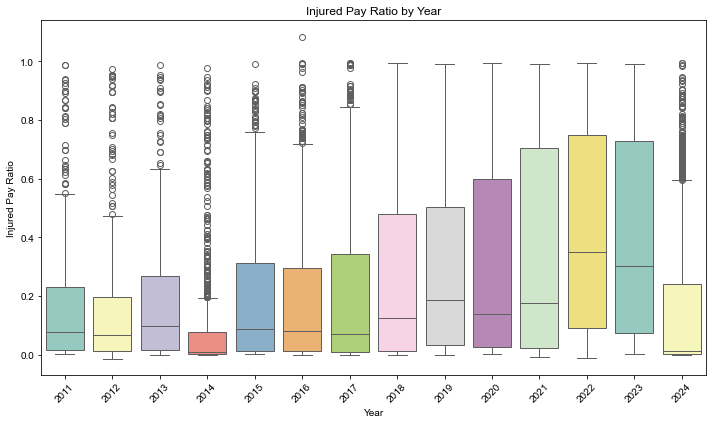

In [35]:
# Plot boxplot of injured pay ratio per year
plt.figure(figsize=(10, 6))
sns.boxplot(x='YEAR', y='INJURED_RATIO', data=bpd_data_dropna, palette='Set3')
plt.title('Injured Pay Ratio by Year')
plt.xlabel('Year')
plt.ylabel('Injured Pay Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:
# Calculate the average injured ratio per year
injured_ratio_avg = bpd_data_dropna['INJURED_RATIO'].groupby(bpd_data_dropna['YEAR']).mean().reset_index(name='INJURED_RATIO')

injured_ratio_avg

,YEAR,INJURED_RATIO
0,2011,0.174445
1,2012,0.171357
2,2013,0.185597
3,2014,0.093860
4,2015,0.217756
5,2016,0.212965
6,2017,0.229184
7,2018,0.264143
8,2019,0.292817
9,2020,0.299839


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_94664/1363492130.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='YEAR', y='INJURED_RATIO', data=injured_ratio_avg, palette='Set2')


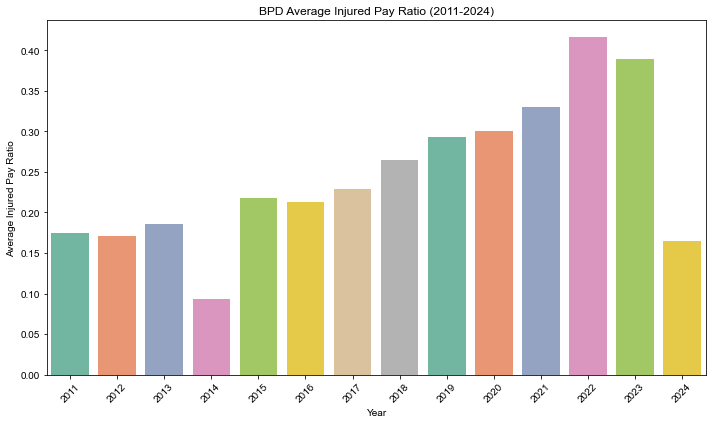

In [43]:
# Plot the average injured ratio per year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='INJURED_RATIO', data=injured_ratio_avg, palette='Set2')
plt.title('BPD Average Injured Pay Ratio (2011-2024)')
plt.xlabel('Year')
plt.ylabel('Average Injured Pay Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# What percentage of officers took injury pay in a given year? 

In [38]:
# Count the number of injured officers each year
injured_counts = bpd_data_dropna.groupby('YEAR')['INJURED'].count().reset_index(name='INJURED_COUNT')
counts = bpd_data.groupby('YEAR')['TOTAL_GROSS'].count().reset_index(name='COUNT')
injured_counts = pd.merge(injured_counts, counts, on='YEAR', how='outer')

#  Calculate the percentage of injured officers
injured_counts['INJURED_PERCENTAGE'] = (injured_counts['INJURED_COUNT'] / injured_counts['COUNT']) * 100

injured_counts


,YEAR,INJURED_COUNT,COUNT,INJURED_PERCENTAGE
0,2011,360,3013,11.948224
1,2012,328,3034,10.810811
2,2013,368,3085,11.928687
3,2014,830,3178,26.117055
4,2015,342,3034,11.272248
5,2016,449,3114,14.418754
6,2017,475,3149,15.084154
7,2018,461,3173,14.528837
8,2019,458,3271,14.001834
9,2020,647,3142,20.591980


/var/folders/64/dkndw9l10ls5pdzpx8fmcqpc0000gn/T/ipykernel_94664/544869917.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='YEAR', y='INJURED_PERCENTAGE', data=injured_counts, palette='Set2')


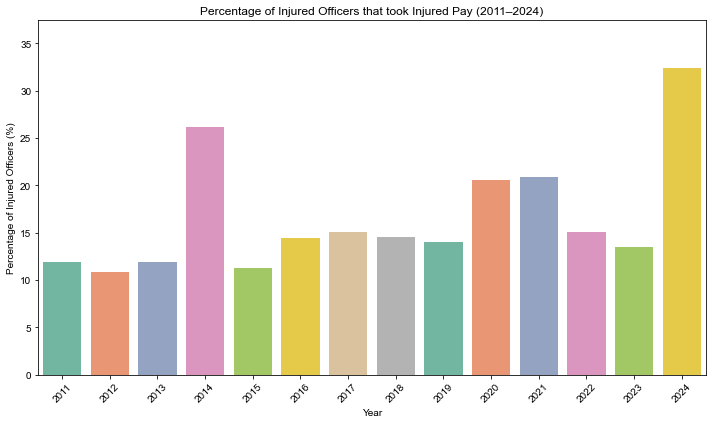

In [44]:

# Plot the percentage of injured officers by year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='INJURED_PERCENTAGE', data=injured_counts, palette='Set2')
plt.title('Percentage of Injured Officers that took Injured Pay (2011–2024)')
plt.xlabel('Year')
plt.ylabel('Percentage of Injured Officers (%)')
plt.xticks(rotation=45)
plt.ylim(0, injured_counts['INJURED_PERCENTAGE'].max() + 5)  # Add some space above the max value
plt.tight_layout()
plt.show()

In [22]:
injured_counts['INJURED_PERCENTAGE'].describe()

count    11.000000
mean     17.994102
std       6.423665
min      11.272248
25%      14.210294
50%      15.084154
75%      20.751711
max      32.426239
Name: INJURED_PERCENTAGE, dtype: float64